In [1]:
import warnings
import logging
warnings.simplefilter("ignore")
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [2]:
import sys
import subprocess

def install_if_missing(package, import_name=None):
    try:
        __import__(import_name or package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Paquete: (pip_name, import_name)
packages = [
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scipy", "scipy"),
    ("statsmodels", "statsmodels"),
    ("scikit-learn", "sklearn"),
    ("kmapper", "kmapper"),
    ("networkx", "networkx"),
]

for pkg, mod in packages:
    install_if_missing(pkg, mod)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import re
from scipy.stats import pearsonr, chi2_contingency
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import kmapper as km
import networkx as nx



In [3]:
def drop_columns_inplace(df, columns):
    """
    Elimina columnas específicas de un df con inplace=True para no consumir memoria. 
    
    Parámetros:
    df (pd.DataFrame): El DataFrame del cual se eliminarán las columnas.
    columns (list): Una lista de nombres de columnas a eliminar.
    
    Raises:
    KeyError: Si alguna de las columnas especificadas no existe en el DataFrame.
    """
    existing_cols = [col for col in columns if col in df.columns]
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        print(f"Algunas columnas no existen en la base de datos: {missing_cols}")
    if existing_cols:
        df.drop(columns=existing_cols, inplace=True)

In [4]:
def load_dataset(filepath, **kwargs):
    """
    Carga un dataset desde un archivo CSV.

    Parámetros: 
        filepath (str): Ruta al archivo CSV.
        **kwargs: Argumentos adicionales para pd.read_csv.

    Returns:
        pd.DataFrame: Datos cargados. 
    """
    try:
        df = pd.read_csv(filepath, **kwargs)
        # Eliminar datos personales
        drop_columns_inplace(df, ['h_nom', 'h_correo_e', 'h_codigop', 'cluster'])
    except Exception as e:
        print(f"Error in loading data: {e}")
        return None
    
    # Convertir espacios a NAs
    df = df.replace(r'^\s*$', np.nan, regex=True)
    # Quitar NAs 
    df = df.dropna(axis=1, how='all')
    # Quitar zero columns
    df = df.loc[:, (df != 0).any(axis=0)]
    # Quitar mostly zero columns
    threshold = 0.98 * len(df)
    df = df.loc[:, (df == 0).sum() < threshold]
    # Descartar columnas sin variabilidad 
    df = df.loc[:, df.nunique() > 1]

    return df

In [ ]:
def convert_columns_type(df, columns, dtype):
    """
    Convierte las columnas especificadas de un DataFrame al tipo de dato indicado.

    Parámetros:
        df (pd.DataFrame): El DataFrame a modificar.
        columns (list): Lista de nombres de columnas a convertir.
        dtype (str): Tipo de dato destino: 'datetime', 'numeric' o 'categorical'.

    Raises:
        ValueError: Si el tipo de dato no es válido.
    """
    for col in columns:
        if col not in df.columns:
            #print(f"Columna '{col}' no encontrada en el DataFrame.")
            continue
        try:
            if dtype == 'datetime':
                df[col] = pd.to_datetime(df[col], errors='coerce')
            elif dtype == 'numeric':
                df[col] = pd.to_numeric(df[col], errors='coerce')
            elif dtype == 'categorical':
                df[col] = df[col].astype('category')
            else:
                raise ValueError("El tipo de dato debe ser 'datetime', 'numeric' o 'categorical'")
        except Exception as e:
            print(f"Error al convertir la columna '{col}': {e}")

In [6]:
def remove_outliers_iqr(series, factor=1.5):
    """
    Remove outliers from a pandas Series using the IQR method.
    Returns a boolean mask where True means the value is not an outlier.

    Parameters:
        series (pd.Series): The input Series.
        factor (float): The IQR multiplier (default 1.5).

    Returns:
        pd.Series: Boolean mask with True for non-outlier values.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return series.between(lower, upper)


In [7]:
def comparar_columnas(df):
    resultados = []
    for col1, col2 in combinations(df.columns, 2):
        iguales = (df[col1] == df[col2]) & ~(df[col1].isna() | df[col2].isna())
        conteo = iguales.sum()
        resultados.append({
            'columna_1': col1,
            'columna_2': col2,
            'valores_iguales': conteo
        })

    return pd.DataFrame(resultados)

In [ ]:
def desglose_fechas(df, columna_fecha, tipo, sufijo):
    """
    Agrega una columna al DataFrame con el nombre del día o del mes extraído de una columna de fechas.

    Parámetros:
        df (pd.DataFrame): El DataFrame a modificar.
        columna_fecha (str): Nombre de la columna de tipo datetime.
        sufijo (str): Sufijo para la nueva columna (ej. 'reservacion', 'entrada', etc).
        tipo (str): 'dia' para día de la semana, 'mes' para mes. Default: 'dia'.
    """
    if columna_fecha not in df.columns:
        #print(f"La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    if tipo == 'dia':
        df[f'dia_{sufijo}'] = df[columna_fecha].dt.day_name()
    elif tipo == 'mes':
        df[f'mes_{sufijo}'] = df[columna_fecha].dt.month_name()
    else:
        #print("El parámetro 'tipo' debe ser 'dia' o 'mes'.")
        return


In [9]:
def get_numeric_and_categorical_columns(df, numeric_as_category = None):
    """
    Distingue entre columnas numéricas y categóricas de un DataFrame, 
    permitiendo especificar columnas numéricas que deben tratarse como categóricas.

    Parámetros:
        df (pd.DataFrame): El DataFrame a analizar.
        numeric_as_category (list, opcional): Lista de columnas numéricas a tratar como categóricas.

    Returns:
        tuple: (lista de columnas numéricas, lista de columnas categóricas)
    """
    if numeric_as_category is None:
        numeric_as_category = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(numeric_as_category).tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.union(numeric_as_category).tolist()
    return numeric_cols, categorical_cols

In [10]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [25]:
def cramers_v_matrix(df_cat):
    cols = df_cat.columns
    matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                matrix.loc[col1, col2] = 1
            else:
                matrix.loc[col1, col2] = cramers_v(df_cat[col1], df_cat[col2])
    return matrix

In [11]:
def encontrar_codo(varianza):
    # Crear los puntos (x, y)
    puntos = np.vstack((range(1, len(varianza)+1), varianza)).T

    # Línea entre primer y último punto
    inicio, fin = puntos[0], puntos[-1]
    linea_vec = fin - inicio
    linea_vec = linea_vec / np.linalg.norm(linea_vec)

    # Calcular distancias perpendiculares desde cada punto a la línea
    distancias = []
    for punto in puntos:
        vec = punto - inicio
        proy = np.dot(vec, linea_vec) * linea_vec
        ort = vec - proy
        distancias.append(np.linalg.norm(ort))

    # Índice del máximo
    codo_idx = int(np.argmax(distancias)) + 1  # +1 porque los componentes empiezan en 1
    return codo_idx


In [ ]:

def main(): 
    # Cargar el dataset
    try:
        df = load_dataset("DATOS.csv")
    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        df = None
    if df is None:
        return
    

    
    
if __name__ == "__main__":
    main() 

Algunas columnas no existen en la base de datos: ['cluster']


In [13]:
df = load_dataset("df_reducido.csv")

Algunas columnas no existen en la base de datos: ['h_nom', 'h_correo_e', 'h_codigop']


In [14]:
# Quitar todas las variables de año anterior 
cols_to_drop = [col for col in df.columns if col.startswith('aa_')]
drop_columns_inplace(df, cols_to_drop)

# Filtrar columnas iguales
#resultados_iguales = comparar_columnas(df)
drop_columns_inplace(df, ['Cliente_Disp'])

# Quitar columnas sin variabilidad (> 99% valores iguales)
drop_columns_inplace(df, ['ID_Pais_Origen', 'h_tot_hab'])

Algunas columnas no existen en la base de datos: ['Cliente_Disp']


In [15]:
# Corrección de categorías: Fechas 
# Quitar diferentes formatos de la misma fecha
df = df.loc[:, ~df.columns.str.contains('_ok|_okt|aa_')]

# Convertir columnas de fecha a datetime
fec_cols = [col for col in df.columns if '_fec' in col]
convert_columns_type(df, fec_cols, 'datetime')

# Verificar que las fechas de entrada y salida no sean inconsistentes
assert ((df['h_fec_lld'] > df['h_fec_sda']).sum() == 0), "Hay fechas de check-in posteriores a las de check-out."

In [16]:
# Corrección de categorías: Inconsistencias numéricas
# Corregir inconsistencias de h_num_noc
df.loc[df['h_num_noc'], 'h_num_noc'] = df['h_fec_sda'] - df['h_fec_lld']
# Convertir h_num_noc a enteros y no datetime
df['h_num_noc'] = df['h_num_noc'].apply( # type: ignore
    lambda x: x.days if isinstance(x, pd.Timedelta) else int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else None
)

# Hacer que el número de personas sea la suma de adultos y menores
df['h_num_per'] = df['h_num_men'] + df['h_num_adu']

# Mantener solo tarifas positivas
df = df[df['h_tfa_total'] > 0]

# Normalizar tarifa total
df['tfa_xnoche'] = (df['h_tfa_total'] / df['h_num_noc'])
drop_columns_inplace(df, ['tarifa_x_noche'])

# Quitar outliers de tarifa por noche
df = df[remove_outliers_iqr(df['tfa_xnoche'])]

# Quitar grandes outliers de h_num_noc: no estadías de más de 30 días
df = df[df['h_num_noc'] <= 30]

# Quitar grandes outliers de h_num_per: 30 personas
#df = df[df['h_num_per'] < 30]

In [17]:
# Mutación de columnas 
# Agregar días de la semana y meses del año
desglose_fechas(df, 'h_fec_reg', 'dia', 'reservacion')
desglose_fechas(df, 'h_fec_lld', 'dia', 'entrada')
desglose_fechas(df, 'h_fec_sda', 'dia', 'salida')
desglose_fechas(df, 'h_fec_reg', 'mes', 'reservacion')
desglose_fechas(df, 'h_fec_lld', 'mes', 'entrada')
desglose_fechas(df, 'h_fec_sda', 'mes', 'salida')

# Agregar días de anticipación de reserva
df['dias_anticipacion'] = (df['h_fec_lld'] - df['h_fec_reg']).dt.days.clip(lower=0)

# Agregar binaria de cancelación
df['cancelado'] = np.where((df['ID_estatus_reservaciones'] == 2), 1, 0)

# Quitar columnas que generaron las mutaciones
#drop_columns_inplace(df, ['h_fec_lld', 'h_fec_sda', 'h_fec_reg'])

In [18]:
# Preparación para modelo 
# Eliminar columnas que no se consideran necesarias
drop_columns_inplace(df, ['ID_canal', 'ID_estatus_reservaciones', 'Fecha_hoy', 'h_ult_cam_fec'])

# Definir columnas numéricas y categóricas
numeric_as_category = [col for col in df.columns if 'ID_' in col] + ['cancelado']
numerical_cols, categorical_cols = get_numeric_and_categorical_columns(df, numeric_as_category)

# Convertir a numéricas y categóricas
convert_columns_type(df, numerical_cols, 'numeric')
convert_columns_type(df, categorical_cols, 'categorical')

# Eliminar filas con NAs
df.dropna(inplace=True)

In [19]:
# Crear nuevo dataset para el modelo
df_model = df[numerical_cols + categorical_cols]

# Quitar columnas no relevantes para el modelo
drop_columns_inplace(df_model, ['ID_Reserva', 'h_res_fec', 'h_fec_lld', 'h_fec_sda', 'h_status', 'ID_estatus', 'entre/fin_reservacion'])

# Quitar columnas que dificultan interpretabilidad
drop_columns_inplace(df_model, ['h_cod_age', 'h_can_res', 'ID_Segmento_Comp'])

# Actualizar las columnas numéricas y categóricas	
numerical_cols, categorical_cols = get_numeric_and_categorical_columns(df_model)

Algunas columnas no existen en la base de datos: ['h_res_fec', 'h_fec_lld', 'h_fec_sda', 'h_status', 'ID_estatus']
Algunas columnas no existen en la base de datos: ['h_cod_age']


In [ ]:
# Pruebas de colinealidad: variables numéricas
# Matriz de correlación para variables numéricas
corr_matrix = df_model[numerical_cols].corr()

# Pruebas de hipótesis para pares con correlación >= 0.6 o <= -0.6
high_corr_pairs = []
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if j > i:
            corr_val = corr_matrix.loc[col1, col2]
            if abs(corr_val) >= 0.6:
                # Prueba de hipótesis de correlación de Pearson
                r, p = pearsonr(df_model[col1], df_model[col2])
                high_corr_pairs.append((col1, col2, r, p))

# Mostrar resultados
# for col1, col2, r, p in high_corr_pairs:
#     print(f"Correlación entre {col1} y {col2}: r={r:.2f}, p-valor={p:.2e}")
#     if p < 0.05:
#         print("Correlación significativa (p < 0.05)")
#     else:
#         print("Correlación NO significativa (p >= 0.05)")

# Selecciona solo las columnas numéricas y elimina filas con NA
X = df_model[numerical_cols]

# Mostrar resultados
# print("VIF para cada variable numérica:")
# for i, col in enumerate(numerical_cols):
#     vif = variance_inflation_factor(X.values, i)
#     print(f"{col}: VIF = {vif:.2f} {'<- Colinealidad alta' if vif > 5 else ''}")

Correlación entre h_num_adu y h_num_per: r=0.92, p-valor=0.00e+00
Correlación significativa (p < 0.05)
Correlación entre h_tfa_total y tfa_xnoche: r=0.64, p-valor=0.00e+00
Correlación significativa (p < 0.05)
VIF para cada variable numérica:
dias_anticipacion: VIF = 1.89 
h_num_adu: VIF = inf <- Colinealidad alta
h_num_men: VIF = inf <- Colinealidad alta
h_num_noc: VIF = 10.88 <- Colinealidad alta
h_num_per: VIF = inf <- Colinealidad alta
h_tfa_total: VIF = 15.51 <- Colinealidad alta
tfa_xnoche: VIF = 13.88 <- Colinealidad alta


In [21]:
# Quitar columnas con colinealidad
drop_columns_inplace(df_model, ['h_num_per', 'h_tfa_total'])

# Actualizar columnas numéricas
numerical_cols, _ = get_numeric_and_categorical_columns(df_model, numeric_as_category)

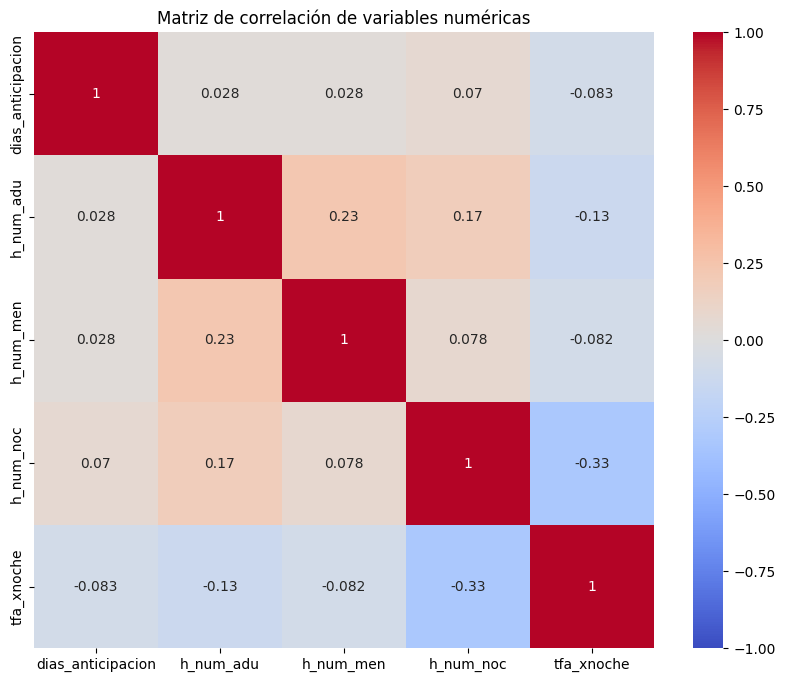

In [22]:
# Matriz de correlación para variables numéricas
corr_matrix = df_model[numerical_cols].corr()
plt.figure(figsize=(10, 8))
plt.title("Matriz de correlación de variables numéricas")
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [ ]:
# Prueba de hipótesis de chi-cuadrada para pares de variables categóricas
chi2_results = []
for i, col1 in enumerate(categorical_cols):
    for j, col2 in enumerate(categorical_cols):
        if j > i:
            tabla = pd.crosstab(df_model[col1], df_model[col2])
            chi2, p, dof, expected = chi2_contingency(tabla)
            # Calcula Cramér's V para el par
            confusion_matrix = tabla
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
            rcorr = r - ((r - 1)**2)/(n - 1)
            kcorr = k - ((k - 1)**2)/(n - 1)
            cramers_value = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            chi2_results.append({
                'col1': col1,
                'col2': col2,
                'chi2': chi2,
                'p_value': p,
                "cramers_v": cramers_value
            })

# Mostrar solo pares con colinealidad relevante
# for res in chi2_results:
#     if res['p_value'] < 0.05 and res['cramers_v'] > 0.35:
#         print(f"{res['col1']} vs {res['col2']}: p-value={res['p_value']:.2e}, Cramér's V={res['cramers_v']:.2f} (colinealidad relevante)")
#     elif res['p_value'] < 0.05:
#         pass
#         #print(f"{res['col1']} vs {res['col2']}: p-value={res['p_value']:.2e}, Cramér's V={res['cramers_v']:.2f} (asociación significativa pero débil)")


ID_Agencia vs ID_Paquete: p-value=0.00e+00, Cramér's V=0.41 (colinealidad relevante)
cancelado vs h_edo: p-value=0.00e+00, Cramér's V=0.37 (colinealidad relevante)
dia_entrada vs dia_salida: p-value=0.00e+00, Cramér's V=0.44 (colinealidad relevante)
mes_entrada vs mes_salida: p-value=0.00e+00, Cramér's V=0.90 (colinealidad relevante)


In [24]:
# Quitar columnas con colinealidad
drop_columns_inplace(df_model, ['ID_Agencia', 'h_edo', 'dia_salida', 'mes_salida'])

# Actualizar columnas numéricas
_, categorical_cols = get_numeric_and_categorical_columns(df_model)

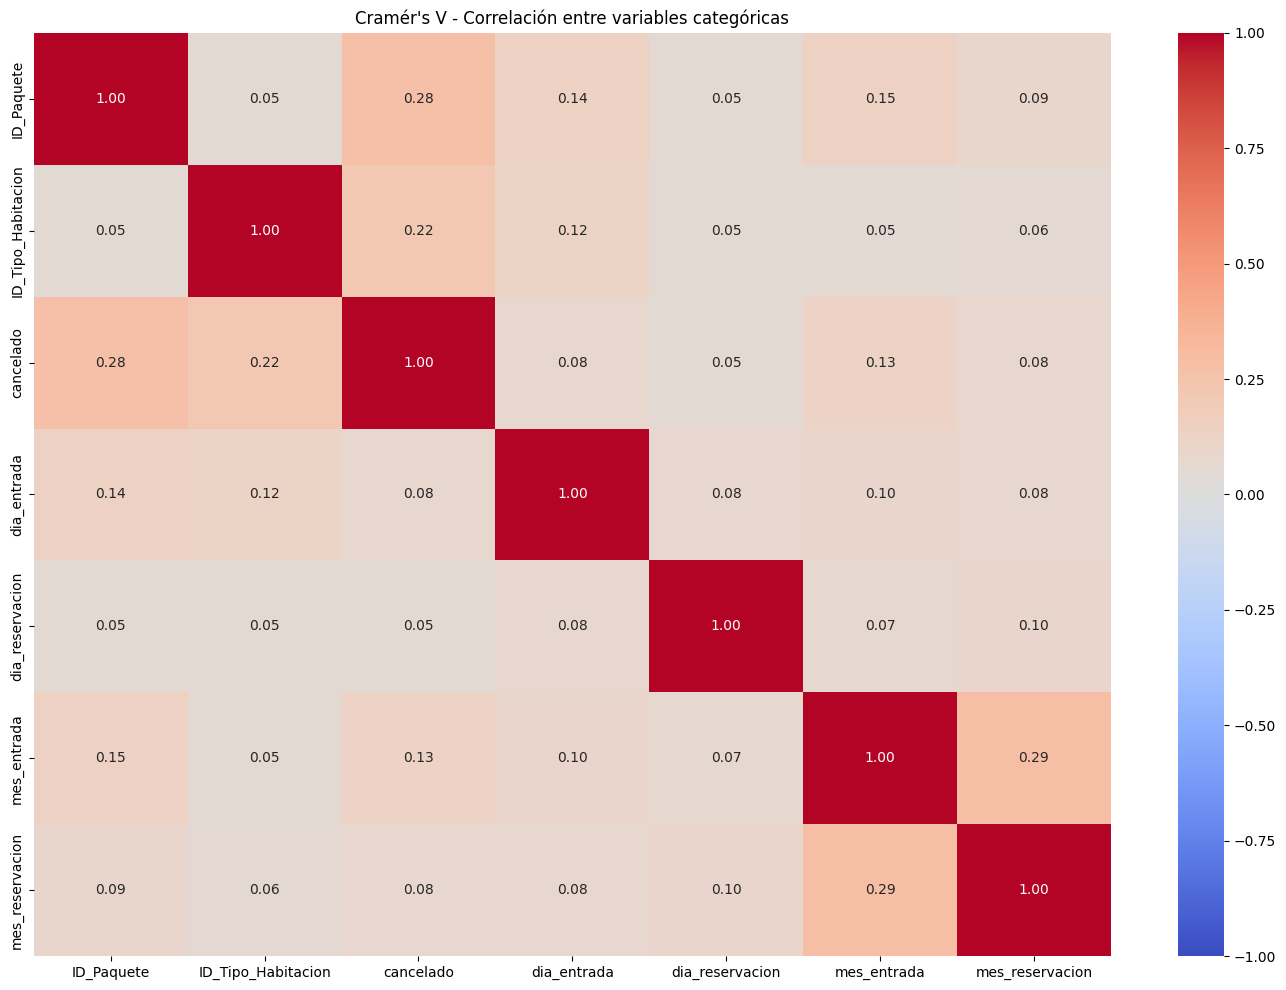

In [26]:
# Pruebas de colinealidad: variables categóricas
# Calcula matriz
cramers_matrix = cramers_v_matrix(df_model[categorical_cols])

# Visualiza con heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cramers_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Cramér's V - Correlación entre variables categóricas")
plt.tight_layout()
plt.show()


In [28]:
# Identificar columnas binarias entre las categóricas
binary_cols = []
for col in categorical_cols[:]:  # [:] para iterar sobre una copia
    if df_model[col].nunique() == 2:
        binary_cols.append(col)
        categorical_cols.remove(col)

In [29]:
# Preparación para modelo numérico
df_num = df_model[numerical_cols + categorical_cols + binary_cols]

In [30]:
# Preparación: Variables cíclicas
# Ciclicidad de días de la semana
day_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

df_num['dia_reservacion'] = df_num['dia_reservacion'].map(day_map).astype(int)
# df_num['dia_reservacion_sin'] = np.sin(2 * np.pi * df_num['dia_reservacion'] / 7)
# df_num['dia_reservacion_cos'] = np.cos(2 * np.pi * df_num['dia_reservacion'] / 7)
# drop_columns_inplace(df_num, ['dia_reservacion'])
df_num['dia_entrada'] = df_num['dia_entrada'].map(day_map).astype(int)
# df_num['dia_entrada_sin'] = np.sin(2 * np.pi * df_num['dia_entrada'] / 7)
# df_num['dia_entrada_cos'] = np.cos(2 * np.pi * df_num['dia_entrada'] / 7)
# drop_columns_inplace(df_num, ['dia_entrada'])

# Ciclicidad de meses del año
mes_map = {
    'January': 0, 'February': 1, 'March': 2, 'April': 3,
    'May': 4, 'June': 5, 'July': 6, 'August': 7,
    'September': 8, 'October': 9, 'November': 10, 'December': 11
}

df_num['mes_reservacion'] = df_num['mes_reservacion'].map(mes_map)
# df_num['mes_reservacion_sin'] = np.sin(2 * np.pi * (df_num['mes_reservacion'].astype('category').cat.codes + 1) / 12)
# df_num['mes_reservacion_cos'] = np.cos(2 * np.pi * (df_num['mes_reservacion'].astype('category').cat.codes + 1) / 12)
# drop_columns_inplace(df_num, ['mes_reservacion'])
df_num['mes_entrada'] = df_num['mes_entrada'].map(mes_map)
# df_num['mes_entrada_sin'] = np.sin(2 * np.pi * (df_num['mes_entrada'].astype('category').cat.codes + 1) / 12)
# df_num['mes_entrada_cos'] = np.cos(2 * np.pi * (df_num['mes_entrada'].astype('category').cat.codes + 1) / 12)
# drop_columns_inplace(df_num, ['mes_entrada'])

In [31]:
df_num.columns

Index(['dias_anticipacion', 'h_num_adu', 'h_num_men', 'h_num_noc',
       'tfa_xnoche', 'ID_Paquete', 'ID_Tipo_Habitacion', 'dia_entrada',
       'dia_reservacion', 'mes_entrada', 'mes_reservacion', 'cancelado'],
      dtype='object')

In [32]:
# Actualizar columnas categóricas
_, categorical_cols = get_numeric_and_categorical_columns(df_num)

In [33]:
# Preprocesamiento: Escalado y codificación
preprocessor = ColumnTransformer([
    #("cyc_mtres", StandardScaler(), ['mes_reservacion_sin', 'mes_reservacion_cos']),
    #("cyc_dtres", StandardScaler(), ['dia_reservacion_sin', 'dia_reservacion_cos']),
    #("cyc_mtlld", StandardScaler(), ['mes_entrada_sin', 'mes_entrada_cos']),
    #("cyc_dtlld", StandardScaler(), []), #['dia_entrada_sin', 'dia_entrada_cos']
    ("num", StandardScaler(), ['h_num_adu', 'h_num_men', 'h_num_noc', 'tfa_xnoche']), #
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['mes_reservacion', 'mes_entrada']), # 'ID_Paquete', 'ID_Tipo_Habitacion'
    #("bin", "passthrough", ['cancelado']) 
    #("bin", OneHotEncoder(drop='if_binary', sparse_output=False), binary_cols)
])

pipeline = Pipeline([
    ("preprocessing", preprocessor)
])

# Ajustar el pipeline al DataFrame
X_transformed = pipeline.fit_transform(df_num)
X_transformed.shape

(88089, 28)

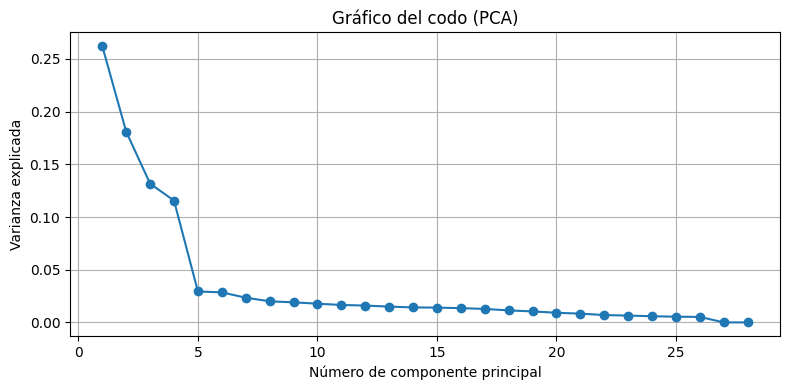

Número óptimo de componentes según el método del codo: 5
Varianza explicada por los primeros 5 componentes: 71.98%


In [34]:
# PCA sin reducción para capturar toda la varianza
pca = PCA()
pca.fit(X_transformed)

# Varianza explicada por cada componente
individual_var = pca.explained_variance_ratio_

# Gráfico del codo
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(individual_var)+1), individual_var, marker='o')
plt.xlabel('Número de componente principal')
plt.ylabel('Varianza explicada')
plt.title('Gráfico del codo (PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular índice del codo
codo = encontrar_codo(individual_var)
print(f"Número óptimo de componentes según el método del codo: {codo}")

# Calcular varianza explicada acumulada hasta el codo
varianza_acumulada = np.sum(individual_var[:codo])
print(f"Varianza explicada por los primeros {codo} componentes: {varianza_acumulada:.2%}")

In [35]:
# Reducción de dimensionalidad: 
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_transformed)

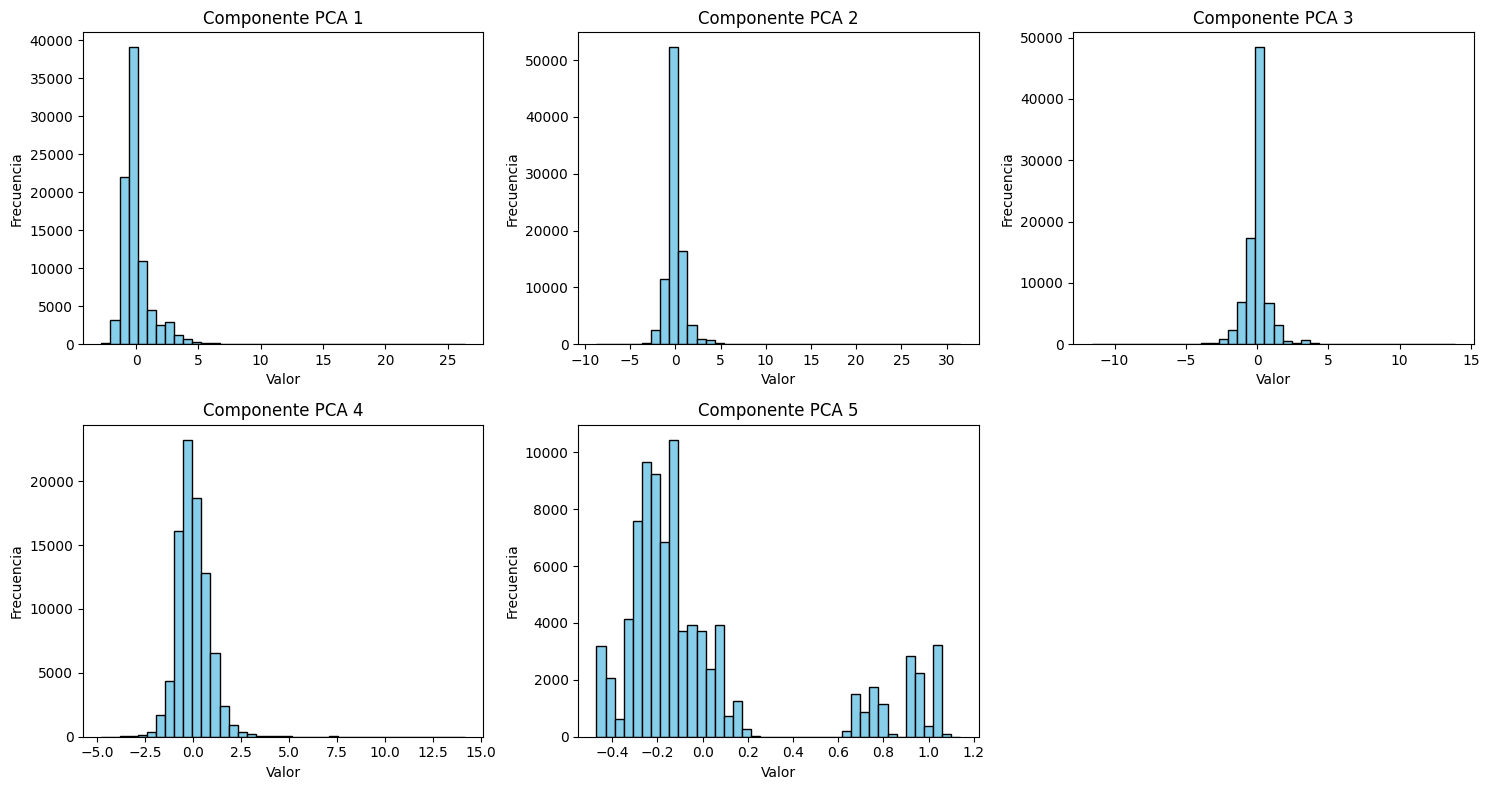

In [36]:
# Histogramas de cada componente principal (PCA)
plt.figure(figsize=(15, 8))
for i in range(X_pca.shape[1]):
    plt.subplot(2, 3, i+1)
    plt.hist(X_pca[:, i], bins=40, color='skyblue', edgecolor='k')
    plt.title(f'Componente PCA {i+1}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [37]:
from scipy.stats import shapiro, normaltest, anderson

# Pruebas de normalidad para cada componente PCA
for i in range(X_pca.shape[1]):
    comp = X_pca[:, i]
    print(f"\nComponente PCA {i+1}:")
    # Shapiro-Wilk (solo para n <= 5000)
    if len(comp) <= 5000:
        stat, p = shapiro(comp)
        print(f"  Shapiro-Wilk: p-value={p:.3g} {'(normal)' if p > 0.05 else '(no normal)'}")
    else:
        print("  Shapiro-Wilk: muestra demasiado grande para la prueba (n > 5000)")
    # D'Agostino and Pearson
    stat, p = normaltest(comp)
    print(f"  D'Agostino-Pearson: p-value={p:.3g} {'(normal)' if p > 0.05 else '(no normal)'}")
    # Anderson-Darling
    result = anderson(comp, dist='norm')
    print(f"  Anderson-Darling: estadístico={result.statistic:.3g}")
    for j, (cv, sig) in enumerate(zip(result.critical_values, result.significance_level)):
        if result.statistic < cv:
            print(f"    Nivel {sig}%: {cv:.3g} (normal)")
        else:
            print(f"    Nivel {sig}%: {cv:.3g} (no normal)")


Componente PCA 1:
  Shapiro-Wilk: muestra demasiado grande para la prueba (n > 5000)
  D'Agostino-Pearson: p-value=0 (no normal)
  Anderson-Darling: estadístico=5.15e+03
    Nivel 15.0%: 0.576 (no normal)
    Nivel 10.0%: 0.656 (no normal)
    Nivel 5.0%: 0.787 (no normal)
    Nivel 2.5%: 0.918 (no normal)
    Nivel 1.0%: 1.09 (no normal)

Componente PCA 2:
  Shapiro-Wilk: muestra demasiado grande para la prueba (n > 5000)
  D'Agostino-Pearson: p-value=0 (no normal)
  Anderson-Darling: estadístico=2.96e+03
    Nivel 15.0%: 0.576 (no normal)
    Nivel 10.0%: 0.656 (no normal)
    Nivel 5.0%: 0.787 (no normal)
    Nivel 2.5%: 0.918 (no normal)
    Nivel 1.0%: 1.09 (no normal)

Componente PCA 3:
  Shapiro-Wilk: muestra demasiado grande para la prueba (n > 5000)
  D'Agostino-Pearson: p-value=0 (no normal)
  Anderson-Darling: estadístico=5.22e+03
    Nivel 15.0%: 0.576 (no normal)
    Nivel 10.0%: 0.656 (no normal)
    Nivel 5.0%: 0.787 (no normal)
    Nivel 2.5%: 0.918 (no normal)
    Niv

In [38]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X_pca)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x0000017834F4B600>)

In [39]:
import pandas as pd

grid = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
grid["mean_test_score"] = -grid["mean_test_score"]
grid = grid.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
#grid.sort_values(by="BIC score").head()

In [40]:
from sklearn.mixture import GaussianMixture

# Definir número de clusters
n_clusters_gmm = 4

# Ajustar el modelo GMM sobre los datos PCA
gmm = GaussianMixture(n_components=n_clusters_gmm, covariance_type='full', random_state=42)
clusters_gmm = gmm.fit_predict(X_pca)

# Agregar los clusters al DataFrame
df['cluster_gmm'] = clusters_gmm

In [45]:
df.to_csv("df_gmm.csv", index=False)

In [44]:
from sklearn.metrics import silhouette_score

silhouette_gmm = silhouette_score(X_pca, clusters_gmm)
print(f"Coeficiente de silueta para GMM: {silhouette_gmm:.3f}")

Coeficiente de silueta para GMM: 0.292


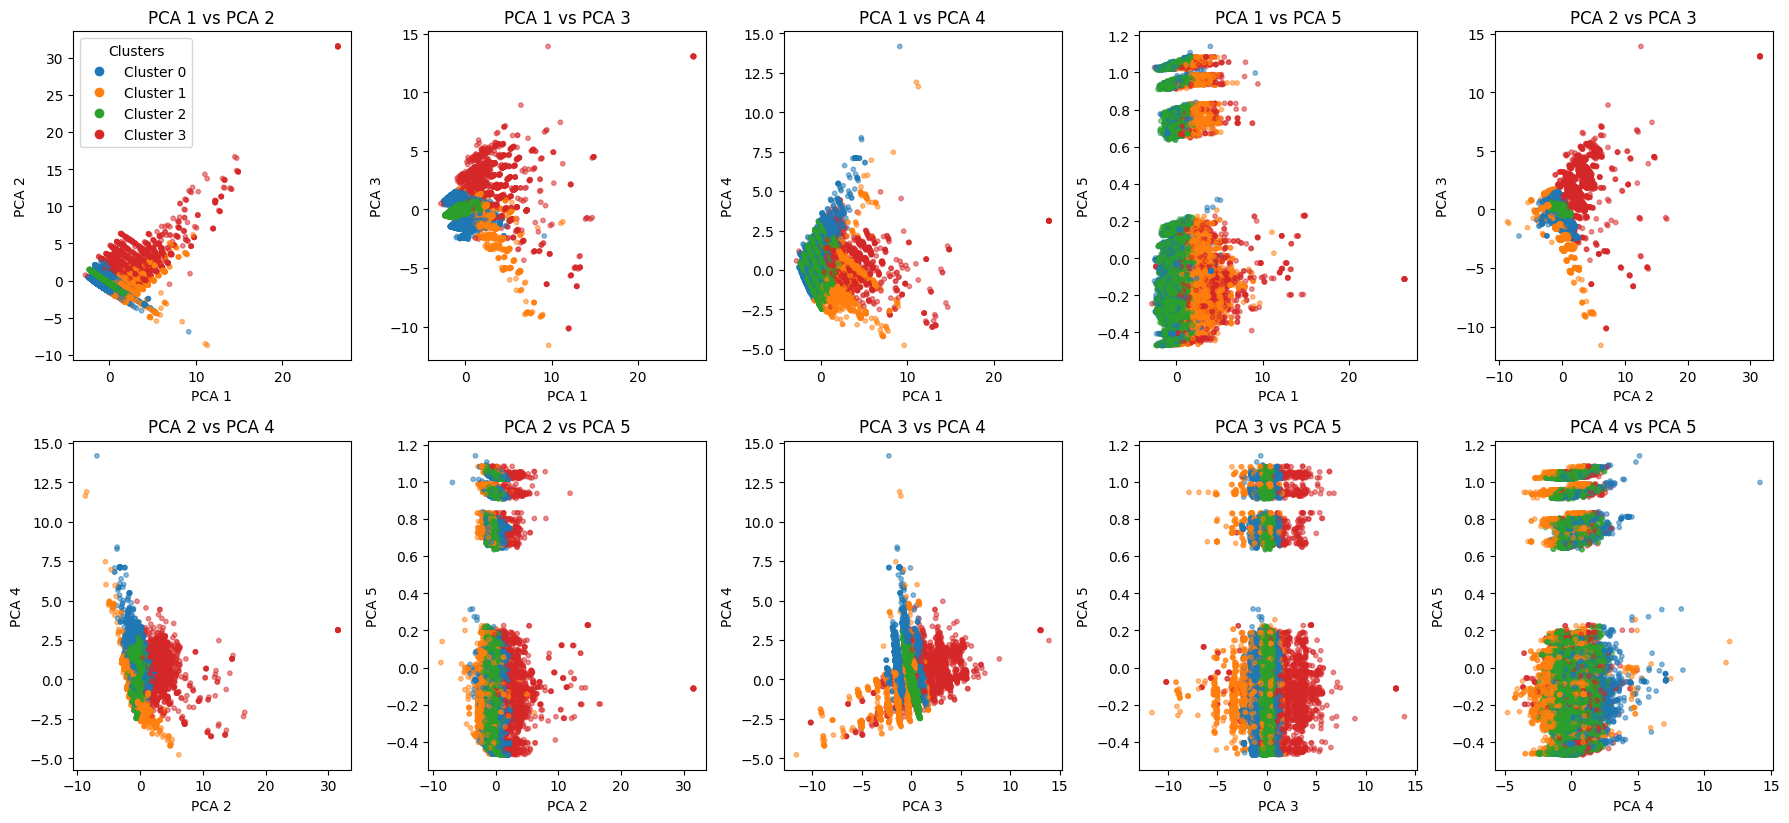

In [46]:
from matplotlib.lines import Line2D

# Visualización de los clusters GMM en todas las combinaciones de componentes PCA con etiquetas de color

n_components = X_pca.shape[1]
plt.figure(figsize=(18, 12))
plot_idx = 1

# Definir colores y etiquetas para los clusters
palette = plt.get_cmap('tab10')
unique_clusters = np.unique(clusters_gmm)
cluster_labels = [f'Cluster {c}' for c in unique_clusters]
colors = [palette(i) for i in unique_clusters]
color_dict = {c: palette(i) for i, c in enumerate(unique_clusters)}
point_colors = [color_dict[c] for c in clusters_gmm]

for i, j in combinations(range(n_components), 2):
    plt.subplot(3, 5, plot_idx)
    scatter = plt.scatter(
        X_pca[:, i], X_pca[:, j], 
        c=point_colors, alpha=0.5, s=10
    )
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel(f'PCA {j+1}')
    plt.title(f'PCA {i+1} vs PCA {j+1}')
    if plot_idx == 1:
        handles = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=8)
                   for label, color in zip(cluster_labels, colors)]
        plt.legend(handles=handles, title="Clusters", loc='best')
    plot_idx += 1

plt.tight_layout()
plt.show()

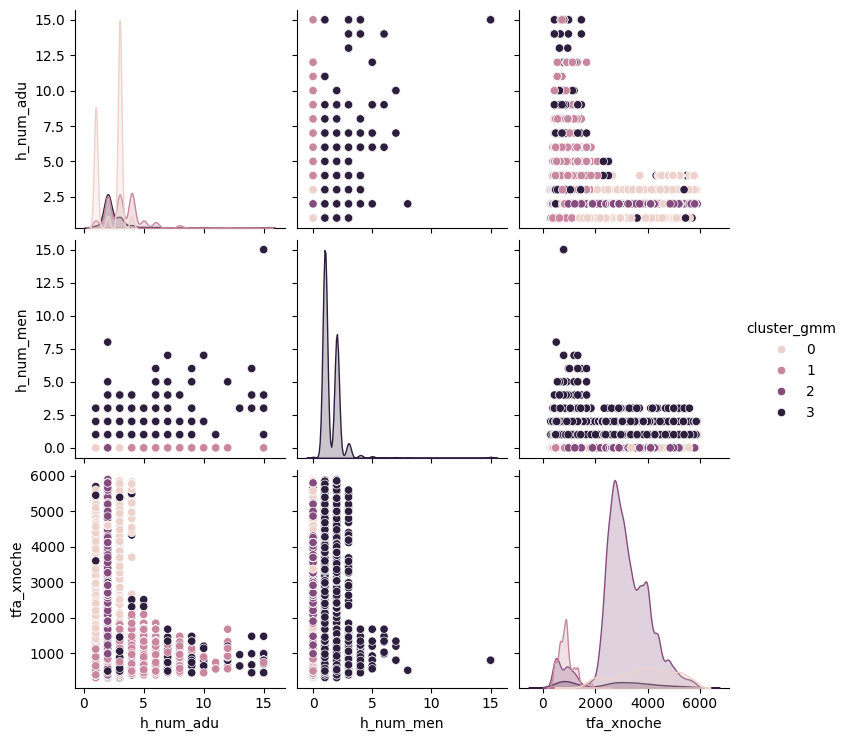

In [47]:
sns.pairplot(df, vars=['h_num_adu', 'h_num_men', 'tfa_xnoche'], hue='cluster_gmm')
plt.show()

In [48]:
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_transformed)
# plt.scatter(X_embedded[:,0], X_embedded[:,1], c=df['cluster_gmm'], cmap='tab10')
# plt.title('Clusters en espacio t-SNE')
# plt.show()